In [1]:
import gc
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import sklearn
from matplotlib import ticker
from sklearn import metrics

import extq
import ivac

In [4]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../")
import plotting
import util

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Load data

In [7]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"  # change this directory name as appropriate for your system
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)

In [8]:
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

In [9]:
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4840184, 3)


In [10]:
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")

# New states

In [84]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# Any points less than
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
# down_ids_square = (dist < -4.24) & (rot < -56.95)
zero = np.zeros_like(dist)
dist_ax_down = np.maximum(dist + 4.240, zero) / 1.1
rot_ax_down = np.maximum(rot + 56.95, zero) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
# include points cut out by salt bridges outside of 
down_ids_alt = (dist < -5.34) & (rot < -64.95) & ~down_ids
down_ids = down_ids | down_ids_alt

# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
dist_ax_up = np.minimum(dist + 0.506, zero) / 0.84
rot_ax_up = np.minimum(rot - 3.94, zero) / 7.6
up_ids = ((dist_ax_up**2 + rot_ax_up**2) < 1) & (sb1 < 0.5) & (sb3 < 1.1) & (sb4 < 0.75) & (sb5 < 0.6)
up_ids_alt = (dist > 0.334) & (rot > 11.5) & ~up_ids
up_ids = up_ids | up_ids_alt

In [85]:
mask = ~(down_ids | up_ids)

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [80]:
assert (np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)) == len(cv_arr)
print(f"Number of down structures:  {len(down_sbs)}")
print(f"Number of up structures:   {len(up_sbs)}")
print(f"Number of other structures: {len(other_sbs)}")

Number of down structures:  259496
Number of up structures:   1216227
Number of other structures: 2674392


In [81]:
random.seed(123)

In [86]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

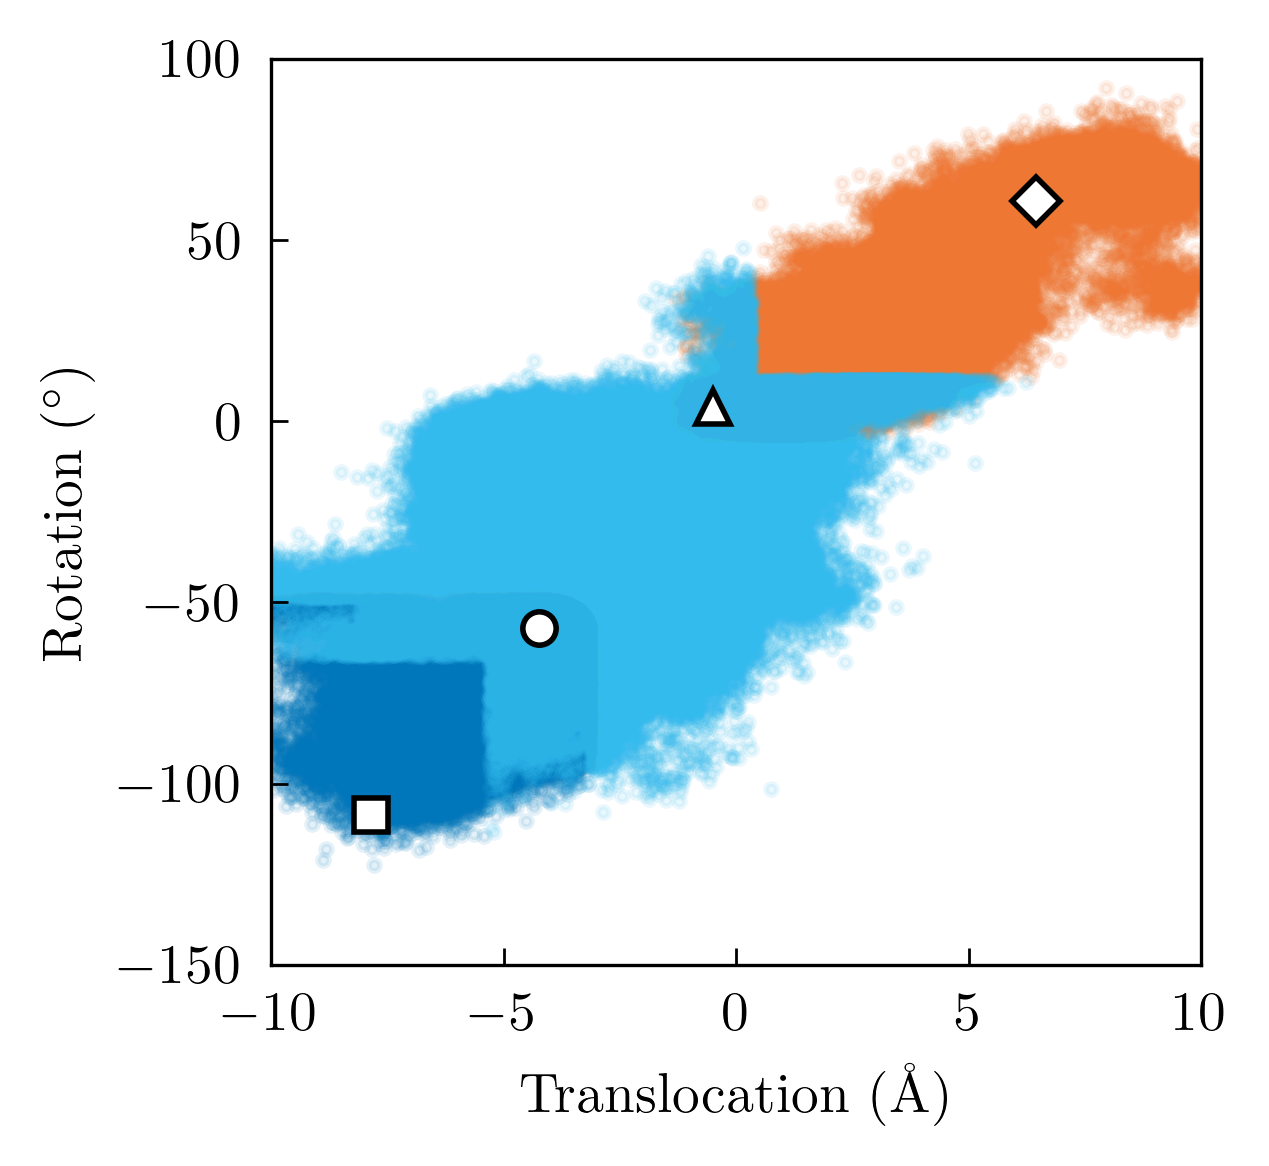

In [88]:
plt.figure(figsize=(3, 3), dpi=200)

plt.scatter(up_cvs[::10, 0], up_cvs[::10, 1], alpha=0.1)
plt.scatter(down_cvs[::10, 0], down_cvs[::10, 1], alpha=0.1)
plt.scatter(other_cvs[::10, 0], other_cvs[::10, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

## compute distance to states

In [89]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [90]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 2

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, down_sbs[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.02% completed
0.04% completed
0.06% completed
0.08% completed
0.10% completed
0.12% completed
0.14% completed
0.16% completed
0.18% completed
0.20% completed
0.22% completed
0.24% completed
0.26% completed
0.28% completed
0.30% completed
0.32% completed
0.34% completed
0.36% completed
0.38% completed
0.40% completed
0.42% completed
0.44% completed
0.46% completed
0.48% completed
0.50% completed
0.52% completed
0.54% completed
0.56% completed
0.58% completed
0.59% completed
0.61% completed
0.63% completed
0.65% completed
0.67% completed
0.69% completed
0.71% completed
0.73% completed
0.75% completed
0.77% completed
0.79% completed
0.81% completed
0.83% completed
0.85% completed
0.87% completed
0.89% completed
0.91% completed
0.93% completed
0.95% completed
0.97% completed
0.99% completed
1.01% completed
1.03% completed
1.05% completed
1.07% completed
1.09% completed
1.11% completed
1.13% completed
1.15% completed
1.17% completed
1.19% completed
1.21% completed
1.23% completed
1.25% co

In [91]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(4150115, 1)


In [ ]:
d_up = []
counter = 0.0
skip = 5

for chunk in metrics.pairwise_distances_chunked(sb_arr, up_sbs[::skip], n_jobs=20, reduce_func=reduce_func):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.01% completed
0.03% completed
0.04% completed
0.05% completed
0.07% completed
0.08% completed
0.09% completed
0.11% completed
0.12% completed
0.13% completed
0.15% completed
0.16% completed
0.17% completed
0.19% completed
0.20% completed
0.21% completed
0.23% completed
0.24% completed
0.25% completed
0.27% completed
0.28% completed
0.29% completed
0.31% completed
0.32% completed
0.33% completed
0.35% completed
0.36% completed
0.37% completed
0.39% completed
0.40% completed
0.41% completed
0.42% completed
0.44% completed
0.45% completed
0.46% completed
0.48% completed
0.49% completed
0.50% completed
0.52% completed
0.53% completed
0.54% completed
0.56% completed
0.57% completed
0.58% completed
0.60% completed
0.61% completed
0.62% completed
0.64% completed
0.65% completed
0.66% completed
0.68% completed
0.69% completed
0.70% completed
0.72% completed
0.73% completed
0.74% completed
0.76% completed
0.77% completed
0.78% completed
0.80% completed
0.81% completed
0.82% completed
0.84% co

In [ ]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

In [ ]:
np.save("../../data/feat2_dist_du_anton2/dist_down_newstate.npy", d_down_arr)
np.save("../../data/feat2_dist_du_anton2/dist_up_newstate.npy", d_up_arr)

# Basis construction

In [ ]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr**2) / (d_down_arr**2 + d_up_arr**2)
guess_up = (d_down_arr**2) / (d_down_arr**2 + d_up_arr**2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [ ]:
print(smooth.shape, guess_down.shape, guess_up.shape)

In [ ]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=300)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2)
# h = ax.scatter(cv_arr[3_000_000:, 0], cv_arr[3_000_000:, 1], c=smooth[3_000_000:], alpha=0.2, cmap=cm_seq)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [ ]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=200, constrained_layout=True)
labels = ("$\psi_{\mathrm{down}}$", "$\psi_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2)
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.0)
    plotting.format_cvs(ax, ms=6)

In [ ]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)

guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(guessU))
print(len(guessD))

In [ ]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

# Committors

## Basis

In [43]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(traj) for traj in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])
print(basisF_arr.shape)

(4150115, 60)


In [44]:
# traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
print(len(in_domain), in_domain[0].shape)

352 (10000,)


In [45]:
qp, qm = [], []
for lag, com in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    qp.append(extq.dga.forward_committor(basis_d, com, in_domain, guessU, lag))
    qm.append(extq.dga.backward_committor(basis_d, com, in_domain, guessD, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000


## Plots

In [49]:
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xe = np.linspace(-10, 10, 101)
ye = np.linspace(-150, 100, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


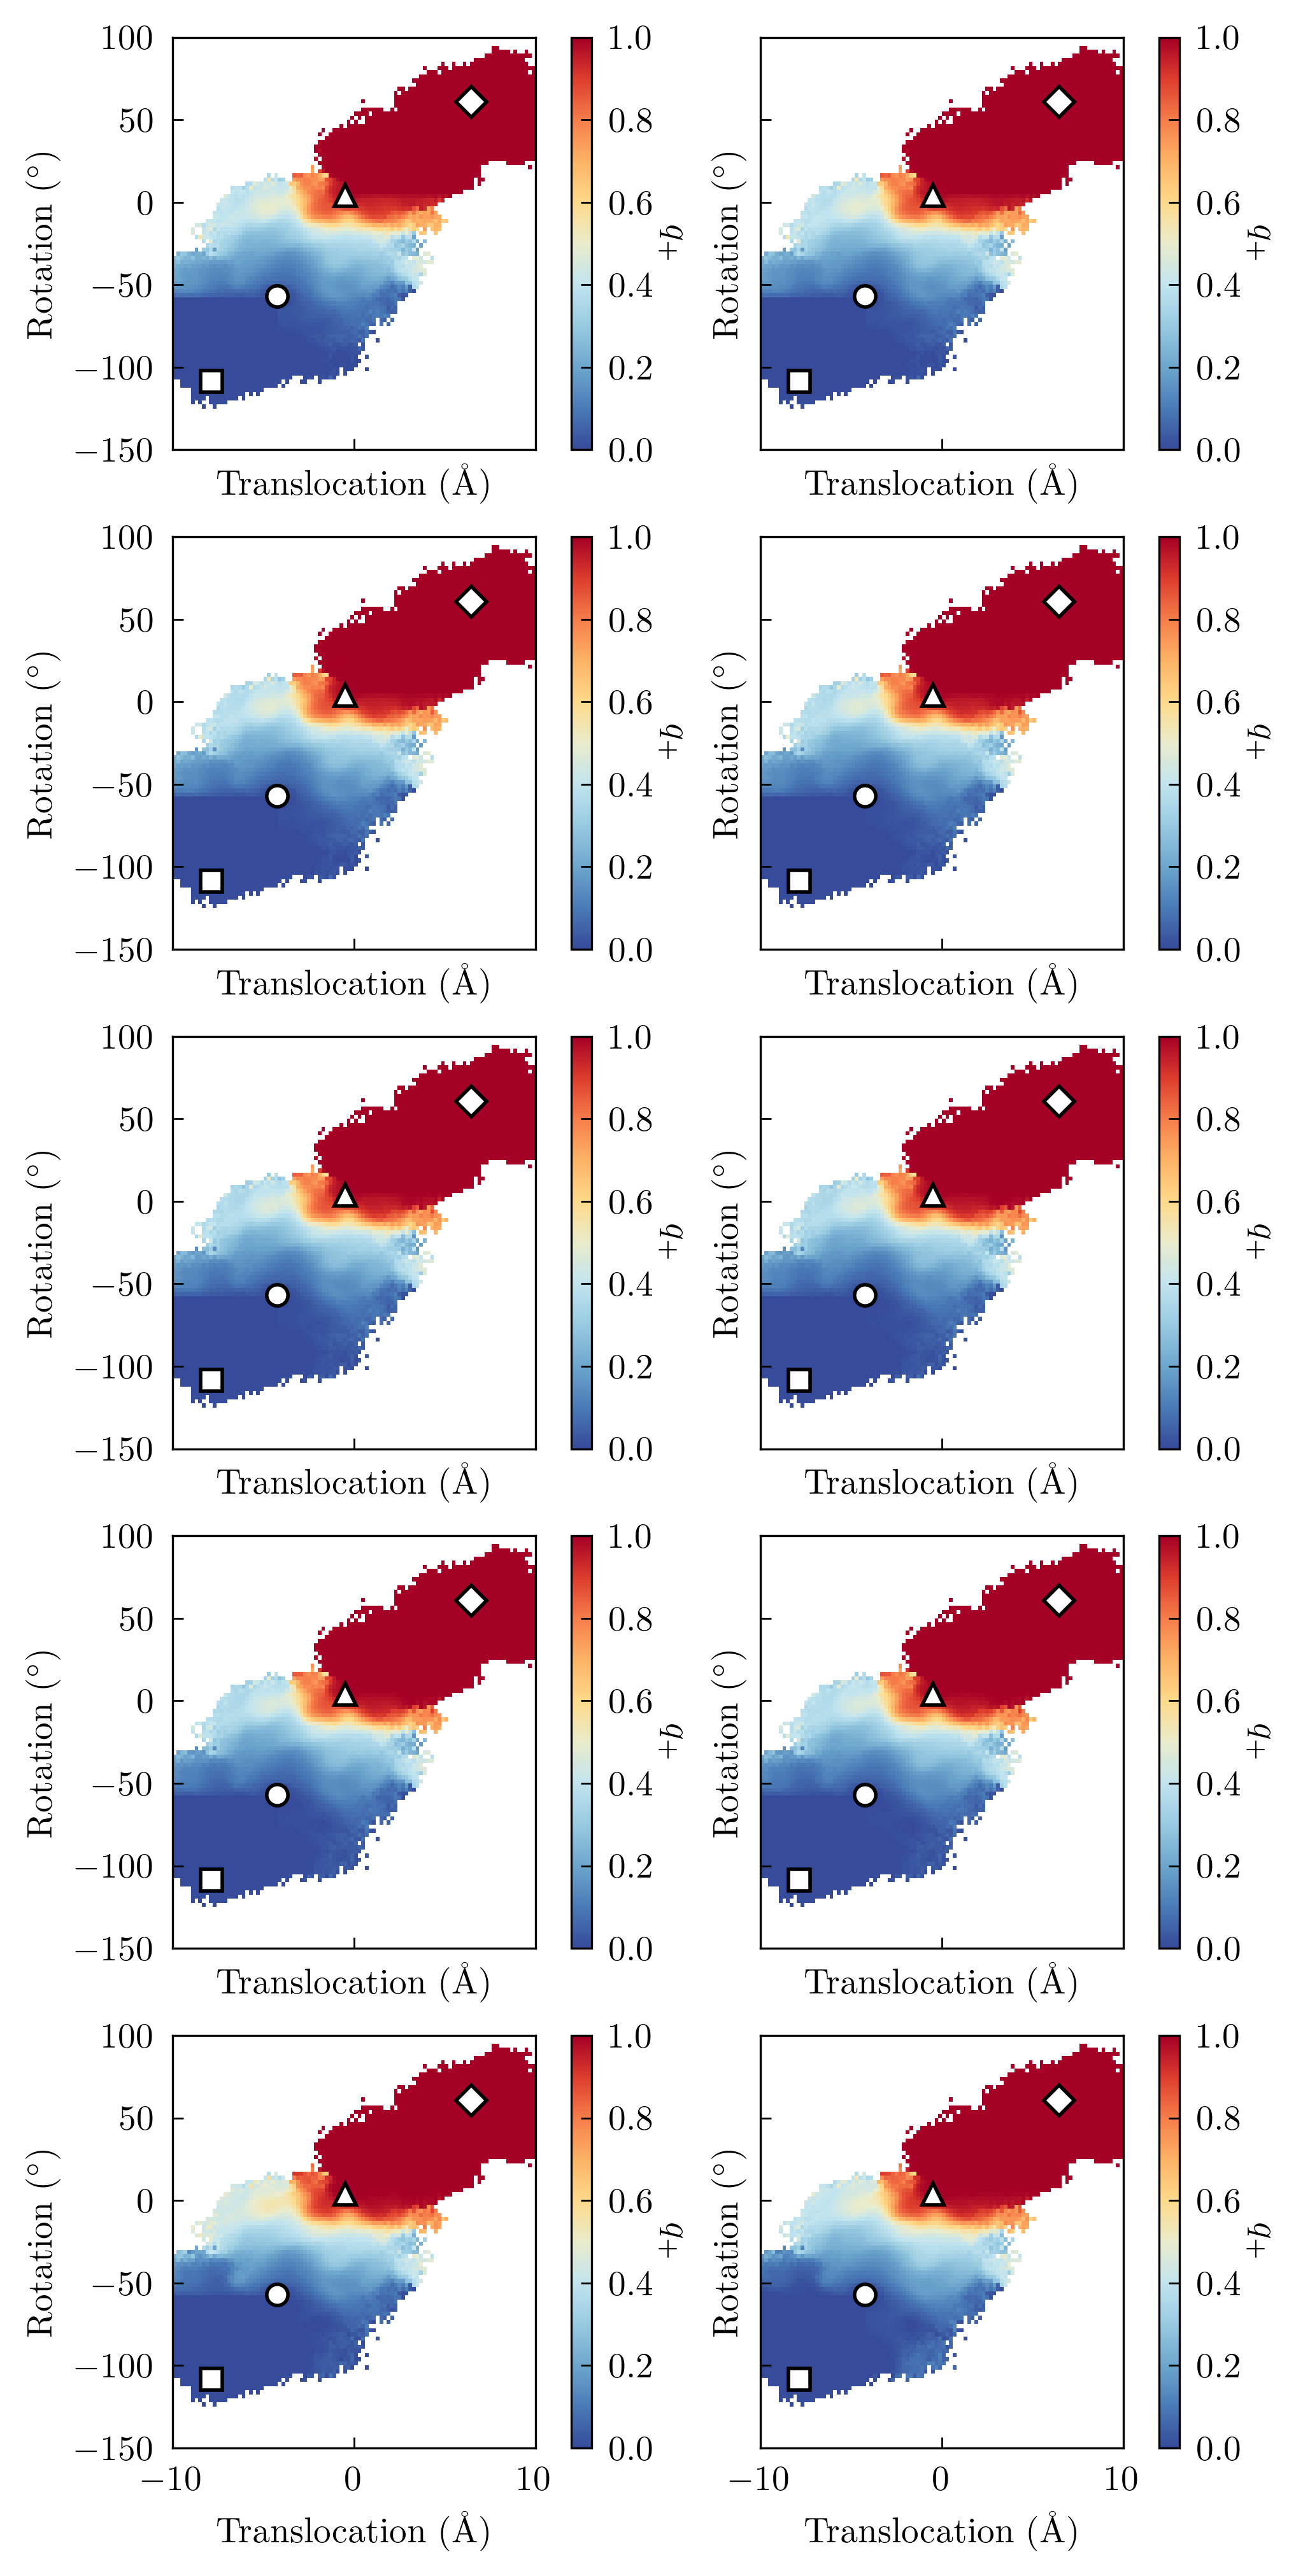

In [51]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
for lag, q, ax in zip(lags, qp, axs.flat):
    q_dens = extq.projection.average2d(dist_trajs, rot_trajs, q, weights[0], xe, ye)
    h = ax.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
    cb = plt.colorbar(h, ax=ax)
    cb.set_label("$q_+$", rotation=-90, labelpad=10)
    plotting.format_cvs(ax, centroids=True, ms=6)

In [52]:
sb_ids = [42, 48, 47, 53]

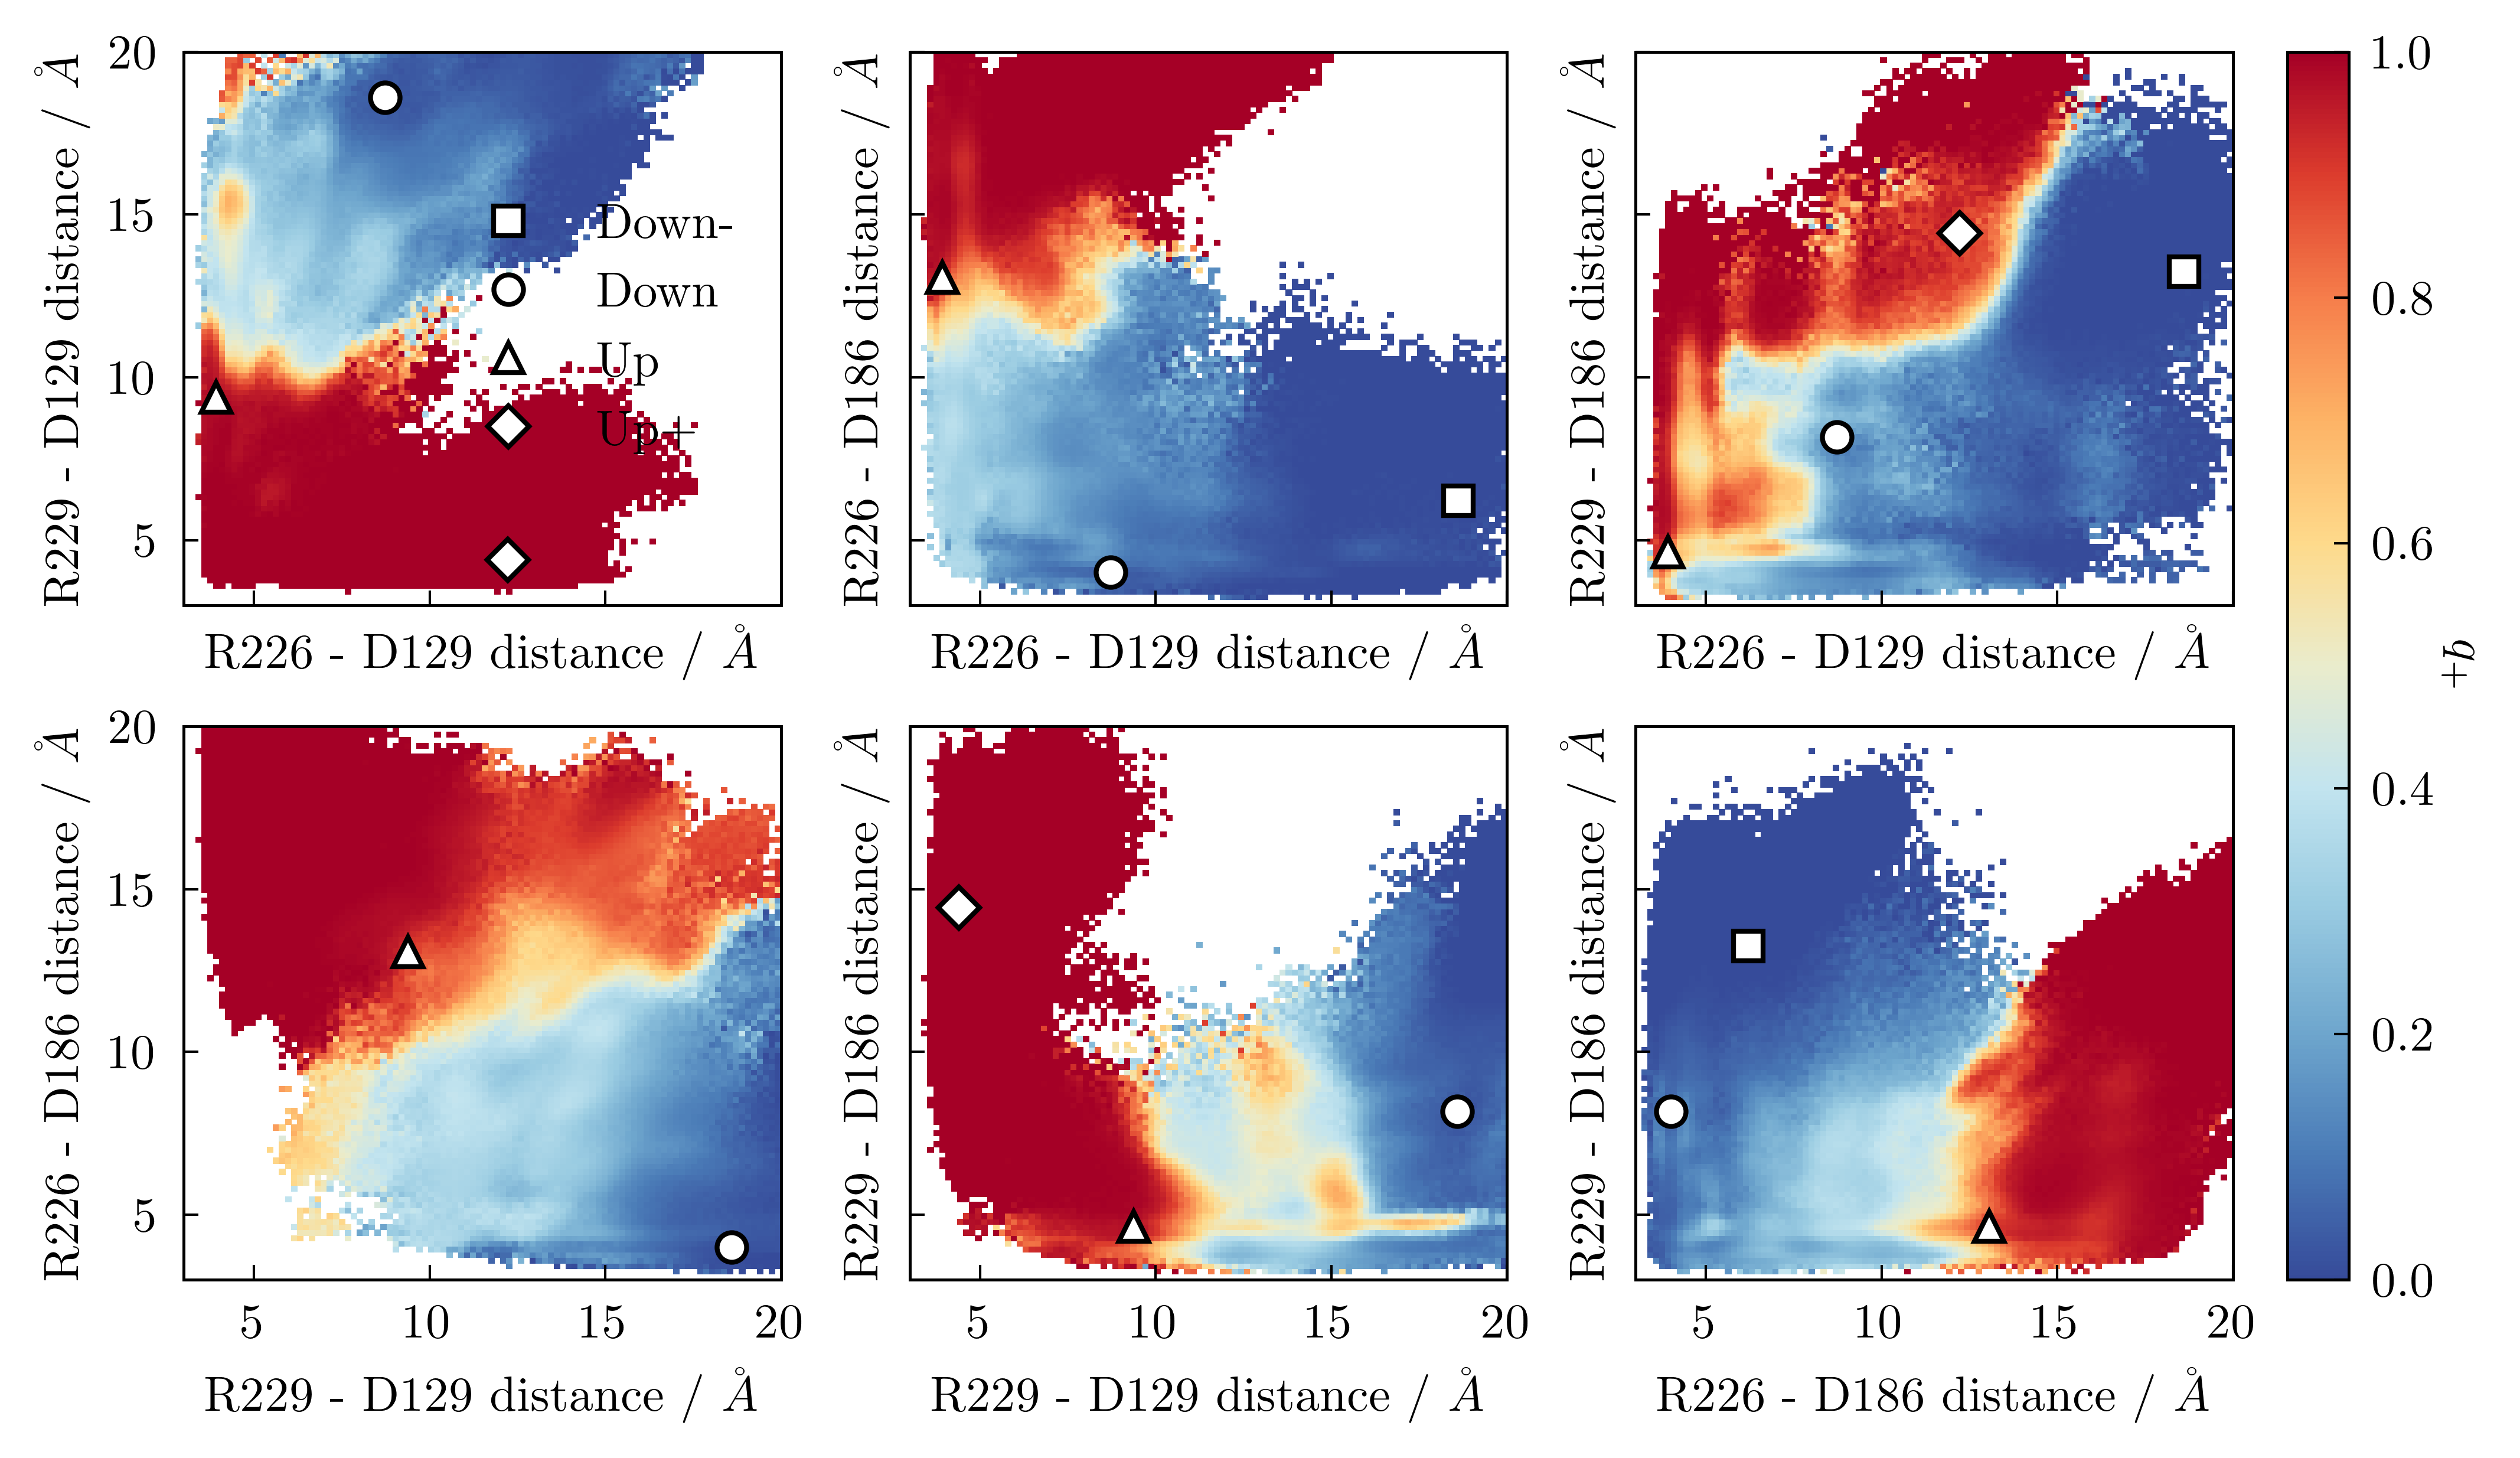

In [53]:
f, axes = plotting.plot_sb_q(
    sb_ids,
    sb_trajs,
    qp[7],
    weights[0],
    centroids=True,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
    bins=100,
    ms=6,
)

axes.flat[0].legend(loc="right")

# Flux

In [56]:
j_sb, j_ds = [], []

for lag, com, fq, bq in zip(lags, weights, qp, qm):
    print(f"Computing currents for down->up, lag = {lag}")
    j = []
    for i in sb_ids:
        sb = [t[:, i] for t in sb_trajs]
        j.append(extq.tpt.current(fq, bq, com, in_domain, sb, lag))
    j_sb.append(np.stack(j, axis=-1))

    j_d = extq.tpt.current(fq, bq, com, in_domain, dist_trajs, lag)
    j_s = extq.tpt.current(fq, bq, com, in_domain, rot_trajs, lag)
    j_ds.append(np.stack((j_d, j_s), axis=-1))

Computing currents for down->up, lag = 1


/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


Computing currents for down->up, lag = 2
Computing currents for down->up, lag = 5
Computing currents for down->up, lag = 10
Computing currents for down->up, lag = 20
Computing currents for down->up, lag = 50
Computing currents for down->up, lag = 100
Computing currents for down->up, lag = 200
Computing currents for down->up, lag = 500
Computing currents for down->up, lag = 1000


In [57]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [59]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [60]:
def plot_pmf_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    n_pmf,
    clines,
    cm_pmf="macaw",
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    xlim = np.linspace(xmin, xmax, n_pmf)
    ylim = np.linspace(ymin, ymax, n_pmf)
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    pmf = extq.projection.density2d(cv1, cv2, weights, xlim, ylim)

    if ax is None:
        ax = plt.gca()
    ax, pc = plotting.plot_pmf(ax, pmf, xlim, ylim, units="kcal", clines=clines, cmap=cm_pmf)
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned**2 + jy_binned**2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.007,
        cmap=cm_j,
        headwidth=2.5,
        headlength=2.5,
        headaxislength=2.5,
        scale=20,
        scale_units="width",
        zorder=5,
    )

    return ax, pc, quiv

In [61]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned**2 + jy_binned**2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

In [62]:
centroids = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/scratch/local/jobs/2010604/ipykernel_3247533/3377859049.py:7: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f6f43a826d0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/2010604/ipykernel_3247533/3377859049.py:7: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f436ddc40> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/2010604/ipykernel_3247533/3377859049.py:20: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol


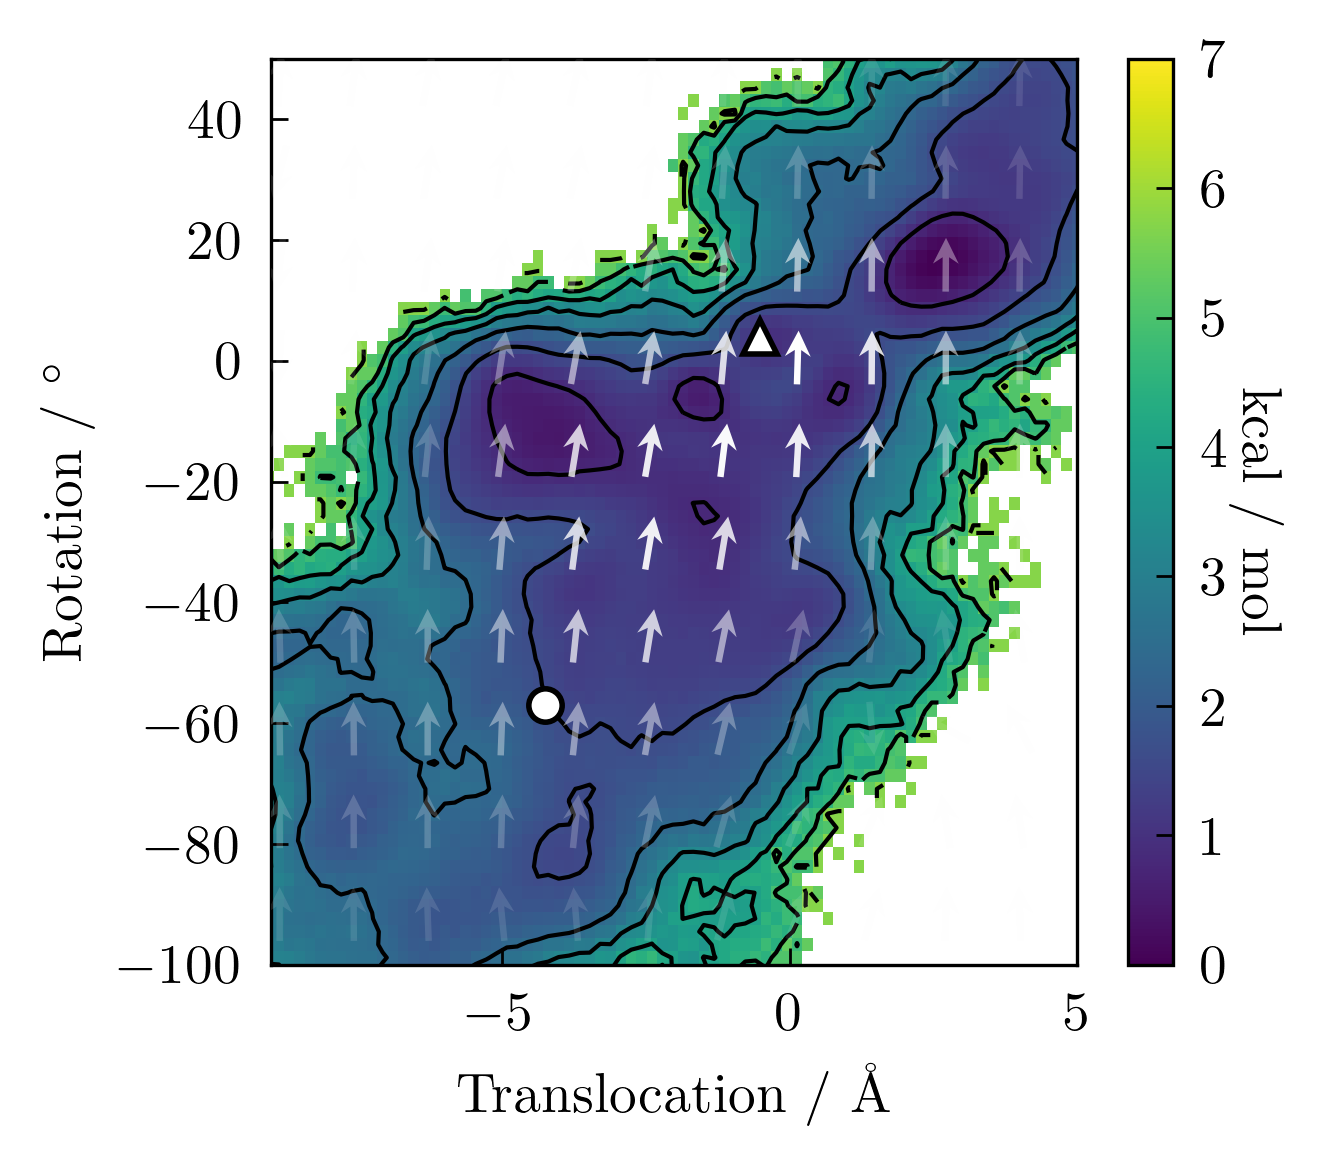

In [68]:
vmin, vmax = 0, 7
clines = np.linspace(vmin, vmax, (vmax - vmin) + 1)  # contour lines spaced every 1 kcal/mol

fig = plt.figure(dpi=200, figsize=(3.25, 3))
ax = plt.gca()
plotting.plot_models(ax, centroids, ms=6, zorder=5)
f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)

# PMF + current
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xe, ye)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol

pc0 = ax.pcolormesh(xcent, ycent, diff.T, vmin=vmin, vmax=vmax, rasterized=True)
ax.contour(xcent, ycent, diff.T, colors="black")
cb = plt.colorbar(pc0, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
# cb.set_ticks(np.linspace(0, 6, 4))
# current
plot_current(dist_trajs, rot_trajs, j_ds[0], weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax)
ax.set(xlim=[-9, 5], ylim=[-100, 50])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

In [72]:
lag = lags[7]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights[0]]

qp_delay = []
for d, t in zip(in_domain, qp[7]):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/scratch/local/jobs/2010604/ipykernel_3247533/1096421182.py:4: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f6f43a826d0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/2010604/ipykernel_3247533/1096421182.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f436ddc40> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)


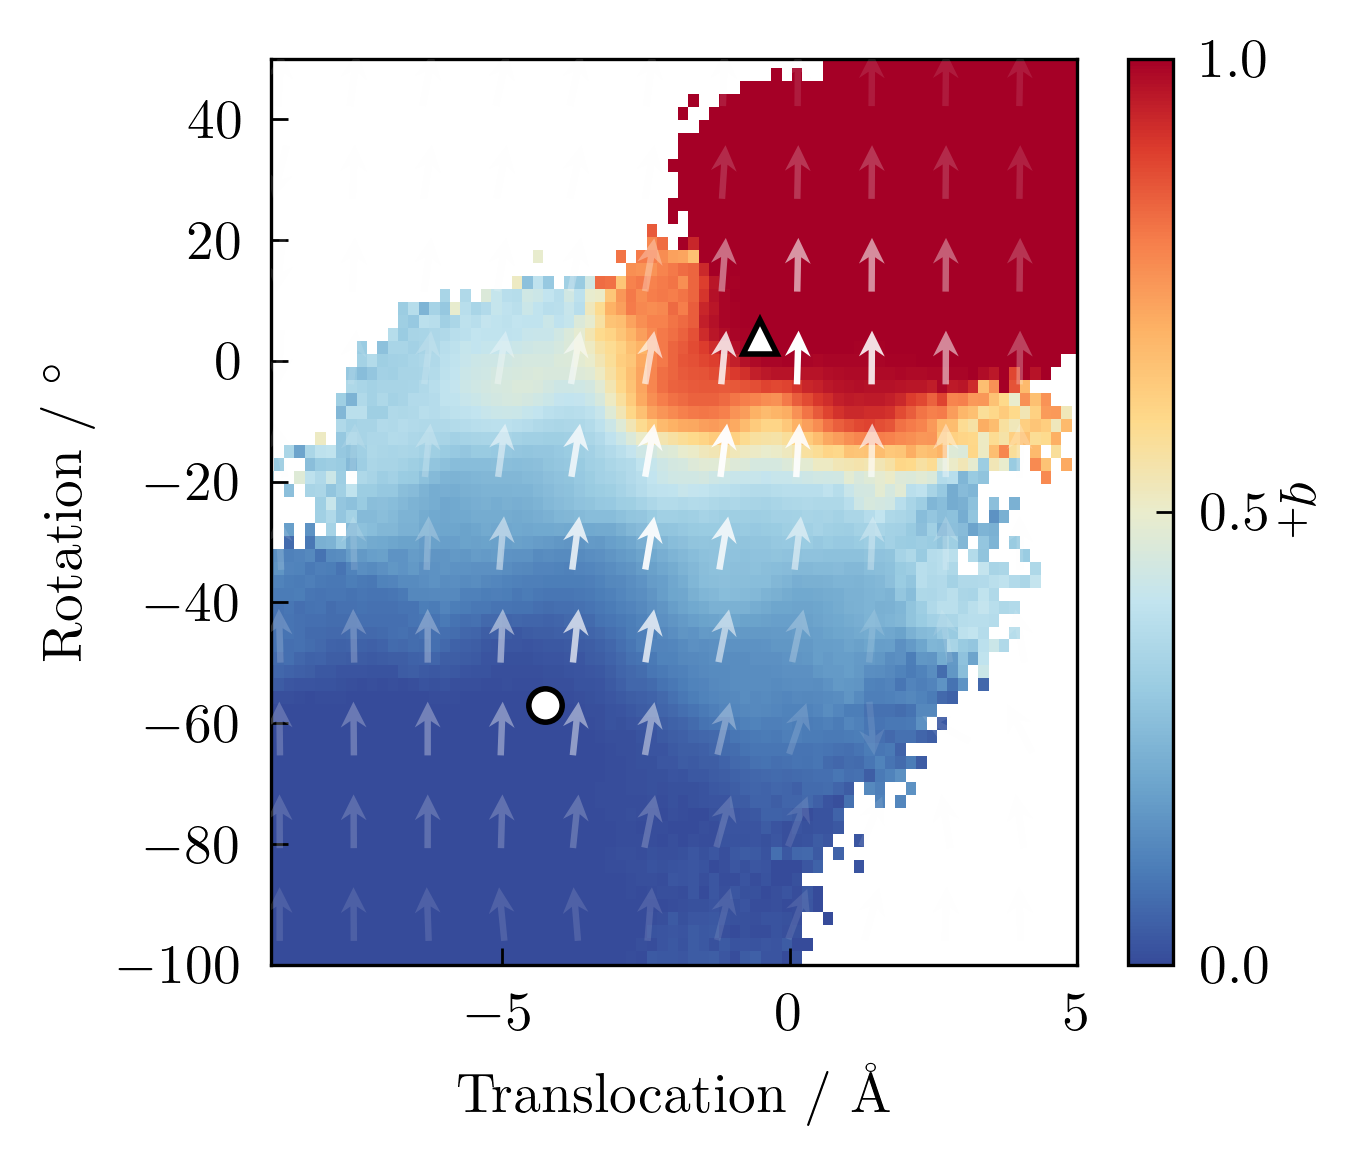

In [75]:
fig = plt.figure(dpi=200, figsize=(3.25, 3))
ax = plt.gca()
plotting.plot_models(ax, centroids, ms=6, zorder=5)
f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)

q_dens = extq.projection.average2d(dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye)
# plot committors
levels = np.linspace(0, 1.0, 51)
pc1 = ax.pcolormesh(xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, rasterized=True)
cb1 = plt.colorbar(pc1, ax=ax)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))

plot_current(dist_trajs, rot_trajs, j_ds[0], weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax)
ax.set(xlim=[-9, 5], ylim=[-100, 50])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

/scratch/local/jobs/2010604/ipykernel_3247533/211936134.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f1fb2ccd0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/2010604/ipykernel_3247533/211936134.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f314fb5b0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)


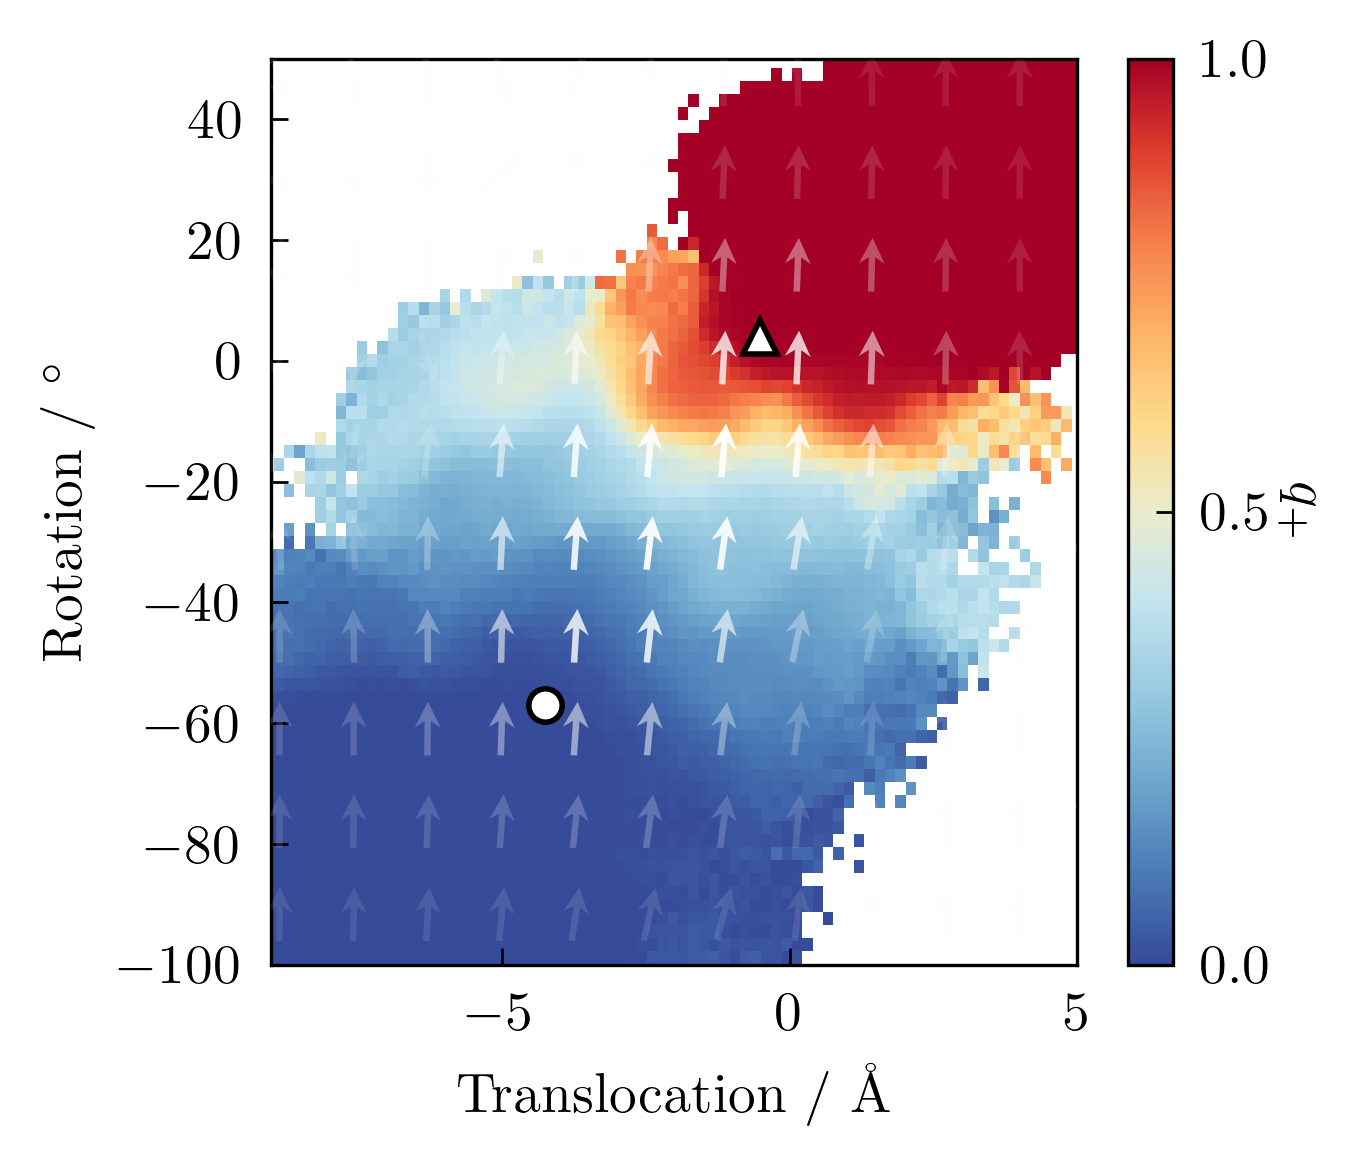

In [83]:
fig = plt.figure(dpi=200, figsize=(3.25, 3))
ax = plt.gca()
plotting.plot_models(ax, centroids, ms=6, zorder=5)
f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)

q_dens = extq.projection.average2d(dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye)
# plot committors
levels = np.linspace(0, 1.0, 51)
pc1 = ax.pcolormesh(xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, rasterized=True)
cb1 = plt.colorbar(pc1, ax=ax)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))

plot_current(dist_trajs, rot_trajs, j_ds[7], weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax)
ax.set(xlim=[-9, 5], ylim=[-100, 50])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

In [76]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

/scratch/local/jobs/2010604/ipykernel_3247533/305285514.py:42: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol


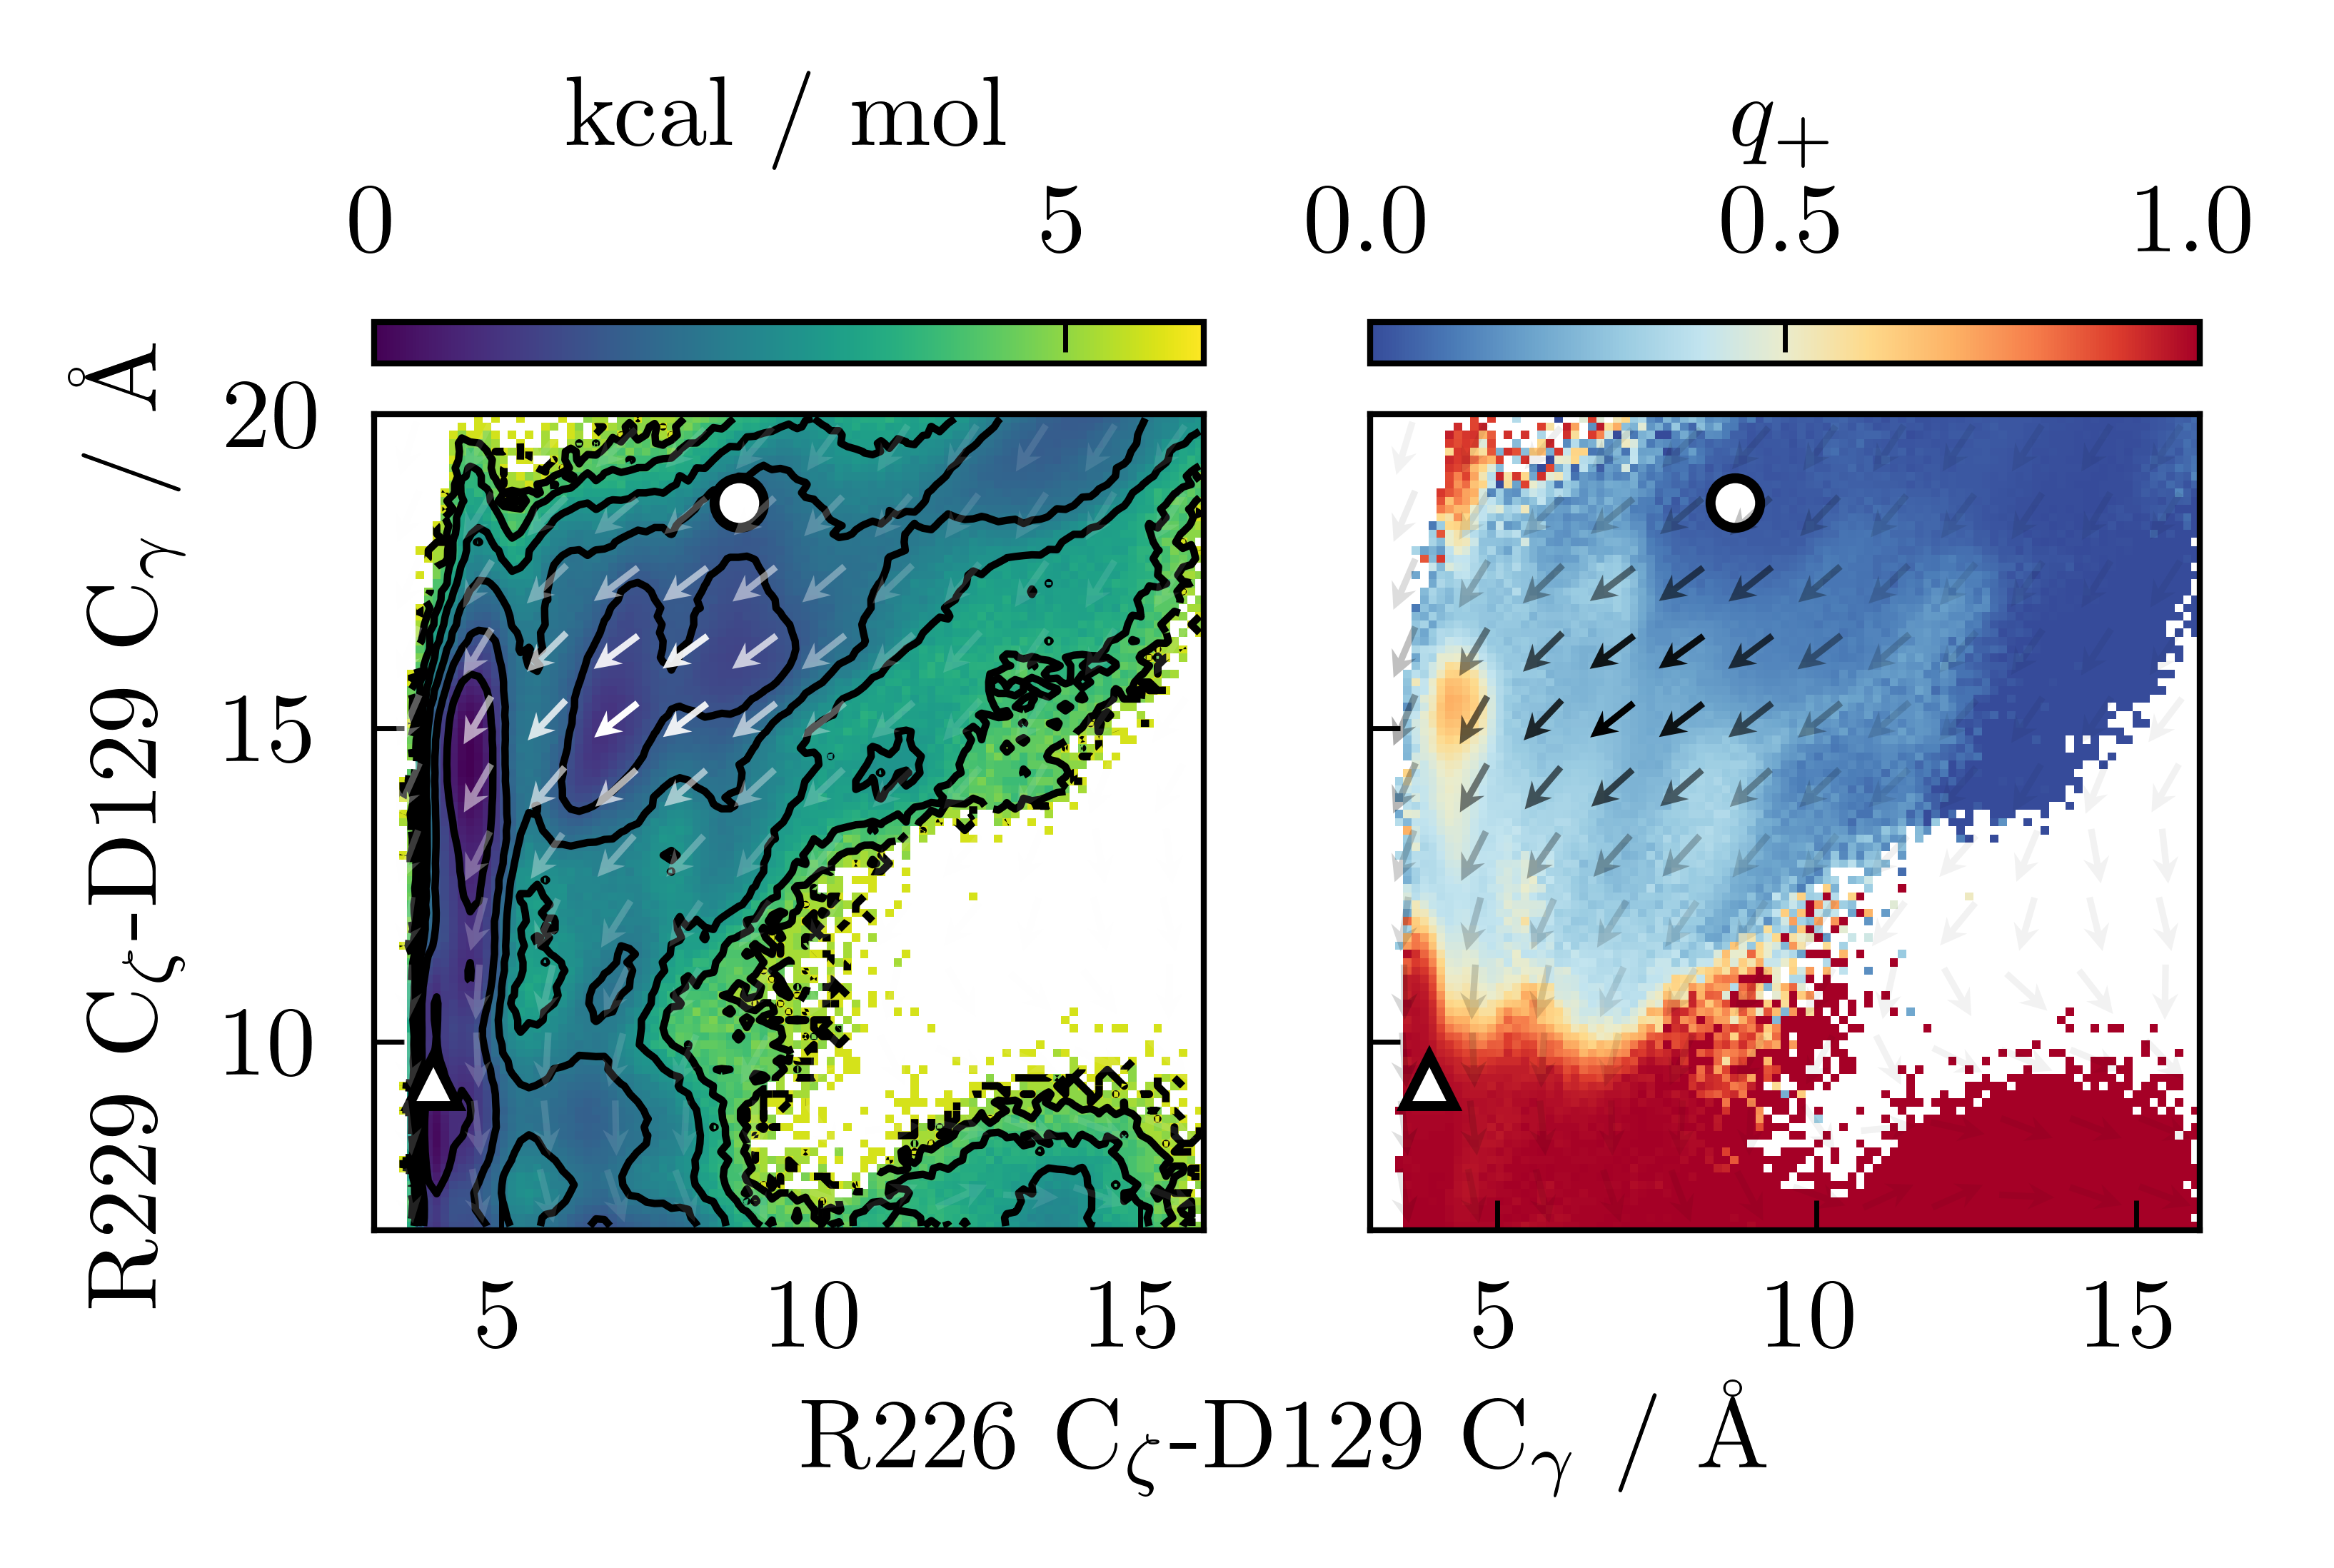

In [82]:
f = plt.figure(figsize=(3.3, 2.1), dpi=500)
ax = f.gca()

xrange = [3, 16]
yrange = [7, 20]
nbin = 100
i, j = 0, 1
sb_ids = [42, 48]
sb1, sb2 = sb_ids[i], sb_ids[j]

ax.set_xlabel(f"{sb_names[sb1]} / Å")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
gs0 = mpl.gridspec.GridSpec(1, 2, bottom=0.2, figure=f)
ax0 = f.add_subplot(gs0[0])
ax1 = f.add_subplot(gs0[1])

sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
xlim = np.linspace(*xrange, nbin)
ylim = np.linspace(*yrange, nbin)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2

sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]

for ax in (ax0, ax1):
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5, zorder=5)
    ax.set(
        ylabel=f"{sb_names[sb2]} / Å",
    )
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.label_outer()
# f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_", 'Down', 'Up'])

# PMF (left)
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights[0], xlim, ylim)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
h = ax0.pcolormesh(xc, yc, diff.T, vmin=0, vmax=6, rasterized=True)
ax0.contour(xc, yc, diff.T, colors="black")
ax0, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_sb[0][:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax0,
    cm_j=cmapwhite,
)
cb = plt.colorbar(h, ax=ax0, orientation="horizontal", location="top")
cb.set_label("kcal / mol")

# Committor
q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
hq = ax1.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1, rasterized=True)
ax1, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_sb[0][:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax1,
    cm_j="black",
)
cb = plt.colorbar(hq, ax=ax1, orientation="horizontal", location="top")
cb.set_label("$q_+$")

/scratch/local/jobs/2010604/ipykernel_3247533/120555245.py:42: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol


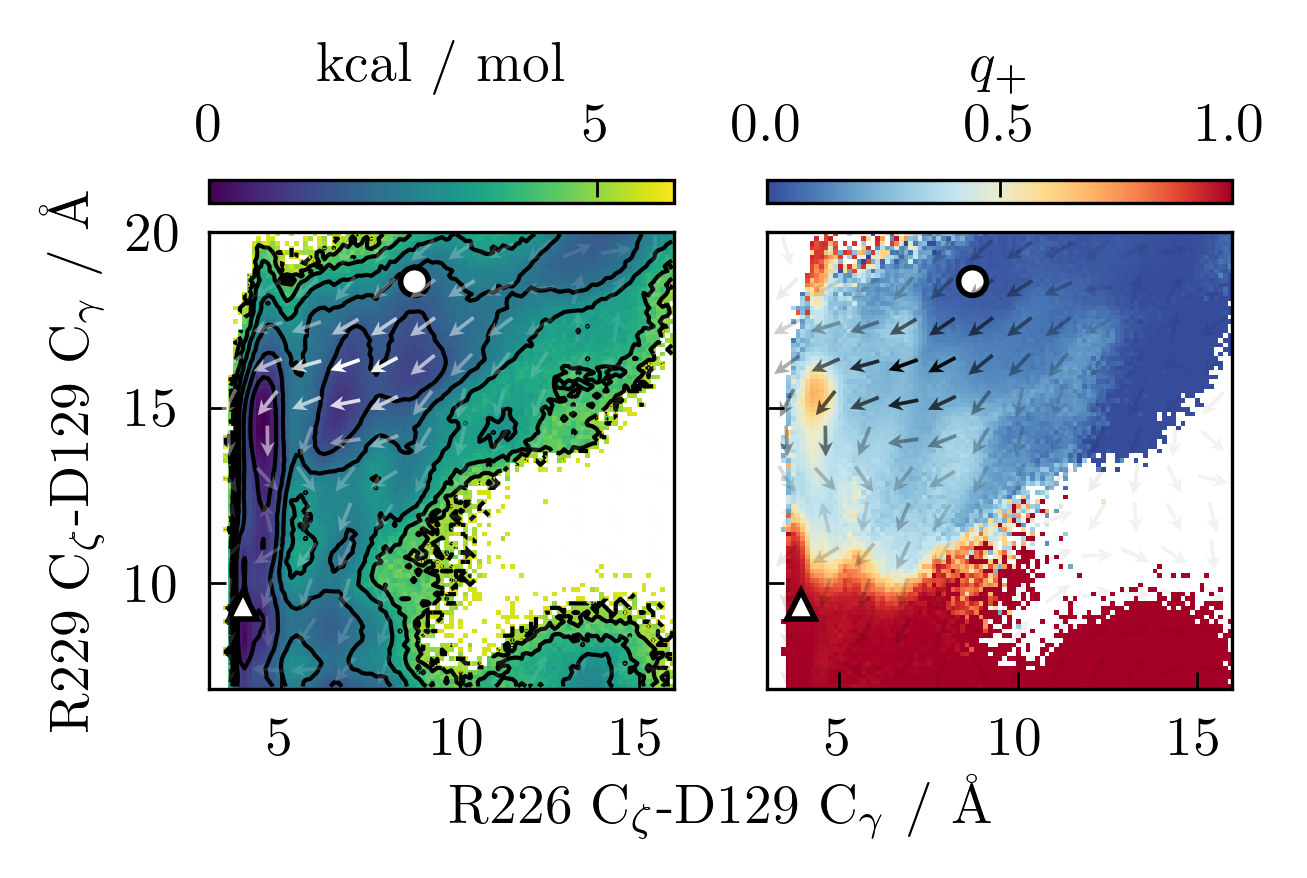

In [84]:
f = plt.figure(figsize=(3.3, 2.1), dpi=200)
ax = f.gca()

xrange = [3, 16]
yrange = [7, 20]
nbin = 100
i, j = 0, 1
sb_ids = [42, 48]
sb1, sb2 = sb_ids[i], sb_ids[j]

ax.set_xlabel(f"{sb_names[sb1]} / Å")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
gs0 = mpl.gridspec.GridSpec(1, 2, bottom=0.2, figure=f)
ax0 = f.add_subplot(gs0[0])
ax1 = f.add_subplot(gs0[1])

sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
xlim = np.linspace(*xrange, nbin)
ylim = np.linspace(*yrange, nbin)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2

sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]

for ax in (ax0, ax1):
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5, zorder=5)
    ax.set(
        ylabel=f"{sb_names[sb2]} / Å",
    )
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.label_outer()
# f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_", 'Down', 'Up'])

# PMF (left)
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights[0], xlim, ylim)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
h = ax0.pcolormesh(xc, yc, diff.T, vmin=0, vmax=6, rasterized=True)
ax0.contour(xc, yc, diff.T, colors="black")
ax0, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_sb[7][:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax0,
    cm_j=cmapwhite,
)
cb = plt.colorbar(h, ax=ax0, orientation="horizontal", location="top")
cb.set_label("kcal / mol")

# Committor
q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
hq = ax1.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1, rasterized=True)
ax1, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_sb[7][:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax1,
    cm_j="black",
)
cb = plt.colorbar(hq, ax=ax1, orientation="horizontal", location="top")
cb.set_label("$q_+$")